In [1]:
#getting and working with data
import pandas as pd
import numpy as np
import re
import os

import scipy.stats as stats

from sklearn.preprocessing import StandardScaler, Normalizer, LabelEncoder, PolynomialFeatures
from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold, train_test_split, cross_val_score, cross_val_predict, GridSearchCV, RandomizedSearchCV

from sklearn.cluster import KMeans
from sklearn.metrics.cluster import silhouette_score

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.svm import SVC 
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn import metrics
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error, roc_auc_score, classification_report
from sklearn.manifold import TSNE
from sklearn.feature_selection import RFECV

import xgboost as xgb

#visualizing results
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
#import yellowbrick as yb

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import warnings; warnings.simplefilter('ignore')
np.set_printoptions(suppress=True)

In [2]:
def feature_importance(X, y, model_instance, feature_names, fi_name):
    #takes in features (X) and classess (y), model, column names for features in X, and name of attribute for feature importance
    #returns dictionary of feature names and coef/feature importance values
    
    feature_importance_dic = {}
    
    model_instance.fit(X, y)
    
    if fi_name == 'coef':
        coef = model_instance.coef_[0]
        feature_importance_dic = dict(zip(feature_names, coef))
    if fi_name == 'feature_importance':
        coef = model_instance.feature_importances_
        feature_importance_dic = dict(zip(feature_names, coef))
    if fi_name == 'none':
        coef = np.zeros(len(feature_names))
        feature_importance_dic = dict(zip(feature_names, coef))
    
    return feature_importance_dic

In [3]:
def classification_pipeline(X, y, cv_instance, model_instance, feature_names, fi_name):
    
    #scale data
    data_scaled = scaler.fit_transform(X)
    
    #generate cross-val sets
    cv = list(cv_instance.split(data_scaled, y))
    
    #predict class and predict probability 
    y_pred = cross_val_predict(model_instance, data_scaled, y, cv=cv, method='predict')
    y_pred_prob = cross_val_predict(model_instance, data_scaled, y, cv=cv, method='predict_proba')
    
    #generate confusion matrix
    conf_mat = confusion_matrix(y, y_pred)
    print('Confusion matrix:', conf_mat)
    
    #generate ROC_AUC
    ROC_AUC = metrics.roc_auc_score(y, y_pred_prob[:,1])
    print("ROC_AUC: ", ROC_AUC)
    
    # generate additional metrics
    recall = metrics.recall_score(y,y_pred)
    precision = metrics.precision_score(y,y_pred)
    accuracy = metrics.accuracy_score(y,y_pred)
    F1 = metrics.f1_score(y,y_pred)
    print("Sensitivity/Recall (TPR): ",recall)
    print("Precision (PPV): ", precision)
    print("Accuracy: ", accuracy)
    print("F1:", F1)
    
    #determine feature importance
    feature_dic = feature_importance(data_scaled, y, model_instance, feature_names, fi_name)
    
    #create dic
    data_dic = {}
    data_dic['y_pred'] = y_pred
    data_dic['y_pred_prob'] = y_pred_prob
    data_dic['conf_mat'] = conf_mat
    data_dic['ROC_AUC'] = ROC_AUC
    data_dic['recall'] = recall
    data_dic['precision'] = precision
    data_dic['accuracy'] = accuracy
    data_dic['F1'] = F1
    
    data_dic = {**data_dic, **feature_dic}
    
    return data_dic

In [4]:
#create a predictions column for subesquent viz of TN, TP, FN, FP
def conf_mat_column(dataframe, model_name):
    preds = []
    for index, row in dataframe.iterrows():

        if (row['Group'] == 0) & (row[model_name] == 0):
            pred = 'TN'
        if (row['Group'] == 0) & (row[model_name] == 1):
            pred = 'FP'
        if (row['Group'] == 1) & (row[model_name] == 1):
            pred = 'TP'
        if (row['Group'] == 1) & (row[model_name] == 0):
            pred = 'FN'
          
        preds.append(pred)
      
    dataframe[str('pred_' + model_name)] = preds
    return dataframe

In [5]:
#from sklearn code

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

### Preprocess data

In [6]:
path = 'C:/Users/Schindler/Documents/Schindler_Lab/Data/Escalation/Phillips/Combined.xlsx'

In [10]:
#excel file containing multiple sheets with rat cocaine self administration data (day 1 of training through reaching criteria)
#original file has multiple sheets (for different feature types) - most sheets have multiple days (columns) of training data
#use first five days and last five days of training as feature data (6 different self administration parameters to use)
#singe data point of days to criterion - use also

whole_file = pd.ExcelFile(path)

print(whole_file.sheet_names)

combined_data = pd.DataFrame()

for sheet_name in whole_file.sheet_names:
    print(sheet_name)

    if sheet_name != 'days2crit':
        
        sheet_data = pd.DataFrame(data = pd.read_excel(whole_file, sheetname=sheet_name, header=None))
        sheet_data.rename({0: 'Group', 1: 'Animal'}, inplace=True, axis=1)
        sheet_data = sheet_data[['Group', 'Animal', 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15,
           16, 17, 18, 19, 20, 21, 22, 23]]

        for index, row in sheet_data.iterrows():
            sheet_data.loc[sheet_data.index[index], str(sheet_name + '_minus_5')] = row.dropna()[-5]
            sheet_data.loc[sheet_data.index[index], str(sheet_name + '_minus_4')] = row.dropna()[-4]
            sheet_data.loc[sheet_data.index[index], str(sheet_name + '_minus_3')] = row.dropna()[-3]
            sheet_data.loc[sheet_data.index[index], str(sheet_name + '_minus_2')] = row.dropna()[-2]
            sheet_data.loc[sheet_data.index[index], str(sheet_name + '_minus_1')] = row.dropna()[-1]
            
            sheet_data.loc[sheet_data.index[index], str(sheet_name + '_plus1')] = row.dropna()[2]
            sheet_data.loc[sheet_data.index[index], str(sheet_name + '_plus2')] = row.dropna()[3]
            sheet_data.loc[sheet_data.index[index], str(sheet_name + '_plus3')] = row.dropna()[4]
            sheet_data.loc[sheet_data.index[index], str(sheet_name + '_plus4')] = row.dropna()[5]
            sheet_data.loc[sheet_data.index[index], str(sheet_name + '_plus5')] = row.dropna()[6]
            
            sheet_data.loc[sheet_data.index[index], str(sheet_name + '_full_ave')] = row.dropna()[2:].mean()
            
        sheet_data = sheet_data[['Animal', 'Group', 
                                 str(sheet_name + '_plus1'), \
                                str(sheet_name + '_plus2'), \
                                str(sheet_name + '_plus3'), \
                                str(sheet_name + '_plus4'), \
                                str(sheet_name + '_plus5'), \
                                 str(sheet_name + '_minus_5'), \
                                str(sheet_name + '_minus_4'), \
                                str(sheet_name + '_minus_3'), \
                                str(sheet_name + '_minus_2'), \
                                str(sheet_name + '_minus_1'),
                                str(sheet_name + '_full_ave')]]
        
        sheet_data[str(sheet_name + '_last_ave')] = sheet_data.loc[:, str(sheet_name + '_minus_5'): str(sheet_name + '_minus_1')].mean(axis=1)
        sheet_data[str(sheet_name + '_first_ave')] = sheet_data.loc[:, str(sheet_name + '_plus1'): str(sheet_name + '_plus5')].mean(axis=1)
    
    if sheet_name == 'days2crit':
        sheet_data = pd.DataFrame(data = pd.read_excel(whole_file, sheetname=sheet_name, header=None))
        sheet_data.rename({0: 'Group', 1: 'Animal'}, inplace=True, axis=1)
        sheet_data = sheet_data[['Group', 'Animal', 2]]
    
    if combined_data.shape[0] == 0:
        combined_data = sheet_data
    else:
        combined_data = pd.merge(combined_data, sheet_data, how='inner', on=['Animal', 'Group'], suffixes=(sheet_name, sheet_name))

combined_data.reset_index(drop=True, inplace=True)
print(combined_data.shape)
combined_data.rename({2:'days2crit'}, axis=1, inplace=True)
combined_data.head(1)

['actnp', 'Inactnp', 'actTO', 'avgIII', 'inactTO', 'days2crit', 'lat2fir']
actnp
Inactnp
actTO
avgIII
inactTO
days2crit
lat2fir
(80, 81)


,Animal,Group,actnp_plus1,actnp_plus2,actnp_plus3,actnp_plus4,actnp_plus5,actnp_minus_5,actnp_minus_4,actnp_minus_3,actnp_minus_2,actnp_minus_1,actnp_full_ave,actnp_last_ave,actnp_first_ave,Inactnp_plus1,Inactnp_plus2,Inactnp_plus3,Inactnp_plus4,Inactnp_plus5,Inactnp_minus_5,Inactnp_minus_4,Inactnp_minus_3,Inactnp_minus_2,Inactnp_minus_1,Inactnp_full_ave,Inactnp_last_ave,Inactnp_first_ave,actTO_plus1,actTO_plus2,actTO_plus3,actTO_plus4,actTO_plus5,actTO_minus_5,actTO_minus_4,actTO_minus_3,actTO_minus_2,actTO_minus_1,actTO_full_ave,actTO_last_ave,actTO_first_ave,avgIII_plus1,avgIII_plus2,avgIII_plus3,avgIII_plus4,avgIII_plus5,avgIII_minus_5,avgIII_minus_4,avgIII_minus_3,avgIII_minus_2,avgIII_minus_1,avgIII_full_ave,avgIII_last_ave,avgIII_first_ave,inactTO_plus1,inactTO_plus2,inactTO_plus3,inactTO_plus4,inactTO_plus5,inactTO_minus_5,inactTO_minus_4,inactTO_minus_3,inactTO_minus_2,inactTO_minus_1,inactTO_full_ave,inactTO_last_ave,inactTO_first_ave,days2crit,lat2fir_plus1,lat2fir_plus2,lat2fir_plus3,lat2fir_plus4,lat2fir_plus5,lat2fir_minus_5,lat2fir_minus_4,lat2fir_minus_3,lat2fir_minus_2,lat2fir_minus_1,lat2fir_full_ave,lat2fir_last_ave,lat2fir_first_ave
0,2223,1,8.0,17.0,15.0,23.0,19.0,27.0,20.0,21.0,7.0,19.0,18.272727,18.8,16.4,8.0,10.0,5.0,4.0,1.0,1.0,1.0,1.0,1.0,1.0,3.333333,1.0,5.6,2.0,9.0,1.0,3.0,3.0,4.0,3.0,1.0,3.0,3.0,4.583333,2.8,3.6,433.69429,215.425,241.95429,156.70045,198.64611,130.57462,182.12895,170.5415,202.24412,189.33389,205.107868,174.964616,249.284028,0.0,0.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.363636,0.0,0.8,4,68.11,73.63,85.62,42.51,10.25,31.86,77.88,26.81,2640.67,75.58,295.264545,570.56,56.024


In [11]:
combined_data['Group'] = combined_data['Group'].replace({2:0})
combined_data['Group'].value_counts()

0    54
1    26
Name: Group, dtype: int64

### Manual feature selection and model training evaluation

In [ ]:
corr = combined_data[['Group',
                      'actnp_full_ave',
                     'Inactnp_full_ave',
               'actTO_full_ave', 
                'avgIII_full_ave',
                     'inactTO_full_ave',
                     'lat2fir_full_ave',
                      'actnp_first_ave',
                     'Inactnp_first_ave',
               'actTO_first_ave', 
                'avgIII_first_ave',
                     'inactTO_first_ave',
                     'lat2fir_first_ave',
                    'actnp_last_ave',
                     'Inactnp_last_ave',
               'actTO_last_ave', 
                'avgIII_last_ave',
                     'inactTO_last_ave',
                     'lat2fir_last_ave',
                     'days2crit']].corr()
corr['Group'].sort_values()

In [12]:
features_full = ['actnp_plus1', 'actnp_plus2', 'actnp_plus3',
       'actnp_plus4', 'actnp_plus5', 'actnp_minus_5', 'actnp_minus_4',
       'actnp_minus_3', 'actnp_minus_2', 'actnp_minus_1', 
       'actTO_plus1', 'actTO_plus2', 'actTO_plus3', 'actTO_plus4',
       'actTO_plus5', 'actTO_minus_5', 'actTO_minus_4', 'actTO_minus_3',
       'actTO_minus_2', 'actTO_minus_1', 'avgIII_plus1',
       'avgIII_plus2', 'avgIII_plus3', 'avgIII_plus4', 'avgIII_plus5',
       'avgIII_minus_5', 'avgIII_minus_4', 'avgIII_minus_3',
       'avgIII_minus_2', 'avgIII_minus_1', 'inactTO_plus1',
       'inactTO_plus2', 'inactTO_plus3', 'inactTO_plus4', 'inactTO_plus5',
       'inactTO_minus_5', 'inactTO_minus_4', 'inactTO_minus_3',
       'inactTO_minus_2', 'inactTO_minus_1', 
       'days2crit']

features_ave_full = ['actnp_full_ave',
               'actTO_full_ave', 
                     'inactTO_full_ave',
                'avgIII_full_ave',
                     'days2crit']

features_ave_firstlast = ['actnp_first_ave',
               'actTO_first_ave', 
                'avgIII_first_ave',
                          'lat2fir_first_ave',
                    'actnp_last_ave',
               'actTO_last_ave', 
                'avgIII_last_ave',
                     'inactTO_last_ave',
          'days2crit']

features_ave_last = ['actnp_last_ave',
               'actTO_last_ave', 
                'avgIII_last_ave',
                     'inactTO_last_ave',
                    'days2crit']

all_ave = ['actnp_first_ave',
 'Inactnp_first_ave',
               'actTO_first_ave', 
                'avgIII_first_ave',
                     'inactTO_first_ave',
                     'lat2fir_first_ave',
                    'actnp_last_ave',
                     'Inactnp_last_ave',
               'actTO_last_ave', 
                'avgIII_last_ave',
                     'inactTO_last_ave',
                     'lat2fir_last_ave',
        'actnp_full_ave',
                     'Inactnp_full_ave',
               'actTO_full_ave', 
                'avgIII_full_ave',
                     'inactTO_full_ave',
                     'lat2fir_full_ave',
                     'days2crit']


In [ ]:
for param in all_ave:
    print(param)
    sns.barplot(x=combined_data["Group"], y=combined_data[param])
    plt.show()

In [13]:
#split data
train, test = train_test_split(combined_data, test_size = .3, random_state=1, stratify = combined_data['Group'])

Y_train_class = train['Group']
Y_test_class = test['Group']

X_train_full = train[features_full]
X_train_ave_full = train[features_ave_full]
X_train_ave_last = train[features_ave_last]
X_train_ave_firstlast = train[features_ave_firstlast]

X_test_full = test[features_full]
X_test_ave_full = test[features_ave_full]
X_test_ave_last = test[features_ave_last]
X_test_ave_firstlast = test[features_ave_firstlast]

In [14]:
#scale data algo
scaler = StandardScaler()

#k fold algo
strat_k_fold = StratifiedKFold(n_splits=3)

#classifier algos
dm_cv = DummyClassifier(strategy='stratified', random_state=39)
lr_cv = LogisticRegression(random_state=39, class_weight='balanced')
rf_cv = RandomForestClassifier(random_state=39, class_weight='balanced')
svm_cv = SVC(kernel='linear', probability=True, class_weight='balanced') 
knn_cv = KNeighborsClassifier()
gb_cv = GradientBoostingClassifier(random_state=39)
ab_cv = AdaBoostClassifier(random_state=39)

#dic with classifier and feature importance attribute name
models_dic = {'dm_cv': (dm_cv, 'none'), 
              'lr_cv': (lr_cv, 'coef'), 
              'rf_cv': (rf_cv, 'feature_importance'), 
              'svm_cv':(svm_cv, 'coef'), 
              'knn_cv': (knn_cv, 'none'), 
              'gb_cv': (gb_cv, 'feature_importance'), 
              'ab_cv': (ab_cv, 'feature_importance')}

In [ ]:
feature_set = 'full'
feature_names = features_full

data_full_features = {}

for name, model in models_dic.items():
    print(f'{name} model with {feature_set} features:')
    data_full_features[name + '_' + feature_set] = classification_pipeline(X_train_full, Y_train_class, strat_k_fold, model[0], feature_names, model[1])
    print('\n')

In [ ]:
feature_set = 'ave_full'
feature_names = features_ave_full

data_ave_full_features = {}

for name, model in models_dic.items():
    print(f'{name} model with {feature_set} features:')
    data_ave_full_features[name + '_' + feature_set] = classification_pipeline(X_train_ave_full, Y_train_class, strat_k_fold, model[0], feature_names, model[1])
    print('\n')

In [ ]:
feature_set = 'firstlast'
feature_names = features_ave_firstlast

data_firstlast_features = {}

for name, model in models_dic.items():
    print(f'{name} model with {feature_set} features:')
    data_firstlast_features[name + '_' + feature_set] = classification_pipeline(X_train_ave_firstlast, Y_train_class, strat_k_fold, model[0], feature_names, model[1])
    print('\n')

In [ ]:
feature_set = 'ave_last'
feature_names = features_ave_last

data_ave_last_features = {}

for name, model in models_dic.items():
    print(f'{name} model with {feature_set} features:')
    data_ave_last_features[name + '_' + feature_set] = classification_pipeline(X_train_ave_last, Y_train_class, strat_k_fold, model[0], feature_names, model[1])
    print('\n')

In [ ]:
#put dics in pandas df 
final_dic = {**data_full_features, **data_ave_full_features, **data_firstlast_features, **data_ave_last_features}
data_pandas = pd.DataFrame.from_dict(data = final_dic, orient='index')
data_pandas.sort_values('F1', ascending=False)
#data_pandas.sort_index()

In [ ]:
fpr_dm, tpr_dm, thresholds_dm = metrics.roc_curve(Y_train_class, data_ave_full_features['dm_cv_ave_full']['y_pred_prob'][:,1])
fpr_lr, tpr_lr, thresholds_lr = metrics.roc_curve(Y_train_class, data_ave_full_features['lr_cv_ave_full']['y_pred_prob'][:,1])
fpr_rf, tpr_rf, thresholds_rf = metrics.roc_curve(Y_train_class, data_ave_full_features['rf_cv_ave_full']['y_pred_prob'][:,1])
fpr_svm, tpr_svm, thresholds_svm = metrics.roc_curve(Y_train_class, data_ave_full_features['svm_cv_ave_full']['y_pred_prob'][:,1])
fpr_knn, tpr_knn, thresholds_knn = metrics.roc_curve(Y_train_class, data_ave_full_features['knn_cv_ave_full']['y_pred_prob'][:,1])
fpr_ab, tpr_ab, thresholds_ab = metrics.roc_curve(Y_train_class, data_ave_full_features['ab_cv_ave_full']['y_pred_prob'][:,1])


# plot model ROC curves
plt.plot(fpr_dm, tpr_dm, label="dm")
plt.plot(fpr_lr, tpr_lr, label="lr")
plt.plot(fpr_rf, tpr_rf, label="rf")
plt.plot(fpr_svm, tpr_svm, label="svm")
plt.plot(fpr_knn, tpr_knn, label="knn")
plt.plot(fpr_ab, tpr_ab, label="ab")

plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.legend(loc="lower right")
plt.title('Classifer ROCs', fontsize=20)
plt.xlabel('False Positive Rate (1 - Specificity)', fontsize = 15)
plt.ylabel('True Positive Rate (Sensitivity)', fontsize = 15)

In [ ]:
# calculate precision-recall curve
precision_dm, recall_dm, thresholds_pr_dm = metrics.precision_recall_curve(Y_train_class, data_ave_full_features['dm_cv_ave_full']['y_pred_prob'][:,1])
precision_lr, recall_lr, thresholds_pr_lr = metrics.precision_recall_curve(Y_train_class, data_ave_full_features['lr_cv_ave_full']['y_pred_prob'][:,1])
precision_rf, recall_rf, thresholds_pr_rf = metrics.precision_recall_curve(Y_train_class, data_ave_full_features['rf_cv_ave_full']['y_pred_prob'][:,1])
precision_svm, recall_svm, thresholds_pr_svm = metrics.precision_recall_curve(Y_train_class, data_ave_full_features['svm_cv_ave_full']['y_pred_prob'][:,1])
precision_knn, recall_knn, thresholds_pr_knn = metrics.precision_recall_curve(Y_train_class, data_ave_full_features['knn_cv_ave_full']['y_pred_prob'][:,1])
precision_ab, recall_ab, thresholds_pr_ab = metrics.precision_recall_curve(Y_train_class, data_ave_full_features['ab_cv_ave_full']['y_pred_prob'][:,1])

plt.plot(recall_dm, precision_dm, label='dm')
plt.plot(recall_lr, precision_lr, label='lr')
plt.plot(recall_rf, precision_rf, label='rf')
plt.plot(recall_svm, precision_svm, label='svm')
plt.plot(recall_knn, precision_knn, label='knn')
plt.plot(recall_ab, precision_ab, label='ab')

plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.legend(loc="lower right")
plt.title('Classifer Precision vs Recall', fontsize=20)
plt.xlabel('Recall (Sensitivity)', fontsize = 15)
plt.ylabel('Precision', fontsize = 15)

In [ ]:
#scale data for grid search
train_scaled = scaler.fit_transform(X_train_ave_full)

#grid search with cv for ada and ave last features
param_grid = {'n_estimators':(25, 50, 100, 250), 'learning_rate':(0.1, 1.0), 'algorithm':('SAMME', 'SAMME.R')}
scoring = ['accuracy', 'f1', 'precision', 'recall', 'roc_auc']

ab_base = AdaBoostClassifier(random_state=39)

ab_gs = GridSearchCV(ab_base, param_grid, cv=3, scoring = scoring, refit='f1')
ab_gs.fit(train_scaled, Y_train_class)

print("f1:"+str(np.average(cross_val_score(ab_gs, train_scaled, Y_train_class, scoring='f1'))))
print("ROC_AUC:"+str(np.average(cross_val_score(ab_gs, train_scaled, Y_train_class, scoring='roc_auc'))))

print(ab_gs.best_params_)

In [15]:
#use best params

#scale data for grid search
train_scaled = scaler.fit_transform(X_train_ave_full)

ada_best = AdaBoostClassifier(algorithm='SAMME', learning_rate=1.0, n_estimators=50, random_state=39)

print("f1:"+str(np.average(cross_val_score(ada_best, train_scaled, Y_train_class, scoring='f1'))))
print("ROC_AUC:"+str(np.average(cross_val_score(ada_best, train_scaled, Y_train_class, scoring='roc_auc'))))
print("Accuracy:"+str(np.average(cross_val_score(ada_best, train_scaled, Y_train_class, scoring='accuracy'))))

ada_best.fit(train_scaled, Y_train_class)

train_pred_ada = ada_best.predict(train_scaled)
train_pred_prob_ada = ada_best.predict_proba(train_scaled)

print('Adaboost train AUC: {}'.format(ada_best.score(train_scaled, Y_train_class)))
print(classification_report(Y_train_class, train_pred_ada))
print(confusion_matrix(Y_train_class, train_pred_ada))

f1:0.6825396825396824
ROC_AUC:0.7496438746438746
Accuracy:0.7855750487329435
Adaboost train AUC: 0.9821428571428571
              precision    recall  f1-score   support

           0       1.00      0.97      0.99        38
           1       0.95      1.00      0.97        18

   micro avg       0.98      0.98      0.98        56
   macro avg       0.97      0.99      0.98        56
weighted avg       0.98      0.98      0.98        56

[[37  1]
 [ 0 18]]


Confusion matrix, without normalization
[[37  1]
 [ 0 18]]


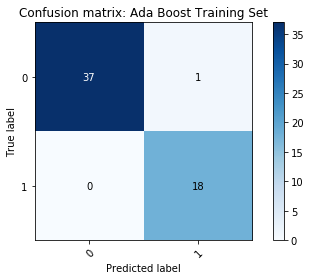

In [26]:
# Plot non-normalized confusion matrix
plot_confusion_matrix(Y_train_class, train_pred_ada, classes=Y_train_class.unique(), normalize=False,
                      title='Confusion matrix: Ada Boost Training Set')



plt.show()

In [17]:
#run on test data
#scale data
test_scaled = scaler.fit_transform(X_test_ave_full)

print('Adaboost test AUC: {}'.format(ada_best.score(test_scaled, Y_test_class)))
test_pred_ada = ada_best.predict(test_scaled)
test_pred_prob_ada = ada_best.predict_proba(test_scaled)
print(classification_report(Y_test_class, test_pred_ada))
print(confusion_matrix(Y_test_class, test_pred_ada))

Adaboost test AUC: 0.7916666666666666
              precision    recall  f1-score   support

           0       0.82      0.88      0.85        16
           1       0.71      0.62      0.67         8

   micro avg       0.79      0.79      0.79        24
   macro avg       0.77      0.75      0.76        24
weighted avg       0.79      0.79      0.79        24

[[14  2]
 [ 3  5]]


Confusion matrix, without normalization
[[14  2]
 [ 3  5]]


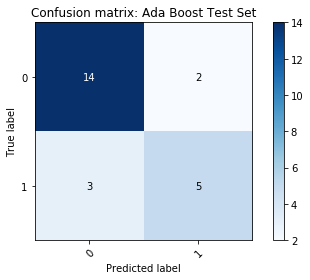

In [27]:
# Plot non-normalized confusion matrix
plot_confusion_matrix(Y_test_class, test_pred_ada, classes=Y_test_class.unique(), normalize=False,
                      title='Confusion matrix: Ada Boost Test Set')



plt.show()

In [ ]:
#scale data for grid search
train_scaled = scaler.fit_transform(X_train_ave_full)

#grid search with cv for svm and ave last features
param_grid = {'C':(0.001, 0.01, 0.1, 1, 10), 'decision_function_shape':('ovo','ovr')}
scoring = ['accuracy', 'f1', 'precision', 'recall', 'roc_auc']

svm_base = SVC(kernel='linear', class_weight='balanced', random_state=39)

svm_gs = GridSearchCV(svm_base, param_grid, cv=3, scoring = scoring, refit='f1')
svm_gs.fit(train_scaled, Y_train_class)

print("f1:"+str(np.average(cross_val_score(svm_gs, train_scaled, Y_train_class, scoring='f1'))))
print("ROC_AUC:"+str(np.average(cross_val_score(svm_gs, train_scaled, Y_train_class, scoring='roc_auc'))))

print(svm_gs.best_params_)

In [ ]:
#use best params

svm_best = SVC(probability=True, kernel='linear', class_weight='balanced', C=10, decision_function_shape='ovo', random_state=39)
    
print("f1:"+str(np.average(cross_val_score(svm_best, train_scaled, Y_train_class, scoring='f1'))))
print("ROC_AUC:"+str(np.average(cross_val_score(svm_best, train_scaled, Y_train_class, scoring='roc_auc'))))
print("Accuracy:"+str(np.average(cross_val_score(svm_best, train_scaled, Y_train_class, scoring='accuracy'))))

svm_best.fit(train_scaled, Y_train_class)
print(svm_best.score(train_scaled, Y_train_class))

train_pred_svm = svm_best.predict(train_scaled)
train_pred_prob_svm = svm_best.predict_proba(train_scaled)
print(classification_report(Y_train_class, train_pred_svm))
print(confusion_matrix(Y_train_class, train_pred_svm))

In [ ]:
#run on test data
#scale data
test_scaled = scaler.fit_transform(X_test_ave_full)

print('SVM test AUC: {}'.format(svm_best.score(test_scaled, Y_test_class)))
test_pred_svm = svm_best.predict(test_scaled)
test_pred_prob_svm = svm_best.predict_proba(test_scaled)
print(classification_report(Y_test_class, test_pred_svm))
print(confusion_matrix(Y_test_class, test_pred_svm))

### Visualize false positives and negative

In [ ]:
#create new columns for each model's pred prob and the best model's pred class
train['class_svm'] = train_pred_svm
train['pred_prob_svm'] = train_pred_prob_svm[:,1]

#create a predictions column for subesquent viz of TN, TP, FN, FP
model_name = 'class_svm'
train = conf_mat_column(train, model_name)
train.head()

In [ ]:
params = ['actnp_full_ave',
               'actTO_full_ave', 
                     'inactTO_full_ave',
                'avgIII_full_ave',
                     'days2crit',
          'pred_prob_svm',
       'pred_class_svm']

i=1
plt.figure(figsize=(30,20))
for param in params:
    print(param)
    plt.subplot(4, 4, i)
    sns.barplot(x=train["Group"], y=train[param], hue=train["pred_class_svm"])
    i = i + 1

In [ ]:
#create new columns for each model's pred prob and the best model's pred class
test['class_svm'] = test_pred_svm
test['pred_prob_svm'] = test_pred_prob_svm[:,1]

#create a predictions column for subesquent viz of TN, TP, FN, FP
model_name = 'class_svm'
test = conf_mat_column(test, model_name)
test.head()

In [ ]:
params = ['actnp_full_ave',
               'actTO_full_ave', 
                     'inactTO_full_ave',
                'avgIII_full_ave',
                     'days2crit',
          'pred_prob_svm',
       'pred_class_svm']

i=1
plt.figure(figsize=(30,20))
for param in params:
    print(param)
    plt.subplot(4, 4, i)
    sns.barplot(x=test["Group"], y=test[param], hue=test["pred_class_svm"])
    i = i + 1

In [ ]:
test_params = test[['Animal', 'Group', 'class_svm', 'pred_prob_svm', 'pred_class_svm', 'actnp_full_ave',
               'actTO_full_ave', 
                     'inactTO_full_ave',
                'avgIII_full_ave',
                     'days2crit']].sort_values('pred_class_svm')

test_params.groupby('pred_class_svm').mean()

In [ ]:
test_params

### Voting Classifier

In [ ]:
#split data
train, test = train_test_split(combined_data, test_size = .3, random_state=1, stratify = combined_data['Group'])

Y_train_class = train['Group']
Y_test_class = test['Group']

X_train_full = train[features_full]
X_train_ave_full = train[features_ave_full]
X_train_ave_last = train[features_ave_last]
X_train_ave_firstlast = train[features_ave_firstlast]

X_test_full = test[features_full]
X_test_ave_full = test[features_ave_full]
X_test_ave_last = test[features_ave_last]
X_test_ave_firstlast = test[features_ave_firstlast]

X_train_scaled = scaler.fit_transform(X_train_ave_full)
X_test_scaled = scaler.fit_transform(X_test_ave_full)
 
eclf1 = VotingClassifier(estimators=[
        ('lr', lr_cv), ('rf', rf_cv), ('svm', svm_cv), ('knn', knn_cv), ('gb', gb_cv), ('ab', ab_cv)], 
                         voting='hard', weights=[5,1,1,1,1,5])
eclf1 = eclf1.fit(X_train_scaled, Y_train_class)
print('Train AUC with hard voting: ', eclf1.score(X_train_scaled, Y_train_class))
print('Test AUC with hard voting: ', eclf1.score(X_test_scaled, Y_test_class))
test_pred_hard = eclf1.predict(X_test_scaled)
print(classification_report(Y_test_class, test_pred_hard))
print(confusion_matrix(Y_test_class, test_pred_hard))

eclf2 = VotingClassifier(estimators=[
        ('lr', lr_cv), ('rf', rf_cv), ('svm', svm_cv), ('knn', knn_cv), ('gb', gb_cv), ('ab', ab_cv)], 
                         voting='soft', weights=[5,1,1,1,1,5])
eclf2 = eclf2.fit(X_train_scaled, Y_train_class)
print('Train AUC with soft voting: ', eclf2.score(X_train_scaled, Y_train_class))
print('Test AUC with soft voting: ', eclf2.score(X_test_scaled, Y_test_class))
test_pred_hard = eclf2.predict(X_test_scaled)
test_pred_prob_hard = eclf2.predict_proba(X_test_scaled)
print(classification_report(Y_test_class, test_pred_hard))
print(confusion_matrix(Y_test_class, test_pred_hard))


### Recursive feature elimination for feature selection and model training evaluation

In [ ]:
data = X_train_ave_full

#scale data
X = scaler.fit_transform(data)
y = Y_train_class

svm_best = SVC(probability=True, kernel='linear', class_weight='balanced', decision_function_shape='ovo', random_state=39)
selector = RFECV(svm_best, step=1, cv=3)
selector = selector.fit(X, y)
feature_rankings = list(zip(data.columns.values, selector.ranking_))

print("Optimal number of features : %d" % selector.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(selector.grid_scores_) + 1), selector.grid_scores_)
plt.show()

feature_rankings

In [ ]:
all_features = ['actnp_first_ave', 'Inactnp_first_ave', 'actTO_first_ave',
       'avgIII_first_ave', 'inactTO_first_ave', 'lat2fir_first_ave',
       'days2crit', 'actnp_last_ave', 'Inactnp_last_ave',
       'actTO_last_ave', 'avgIII_last_ave', 'inactTO_last_ave',
       'lat2fir_last_ave']

cv5_features = ['actnp_first_ave', 'Inactnp_first_ave', 'actTO_first_ave', 'lat2fir_first_ave', 'actnp_last_ave', 
                 'Inactnp_last_ave', 'avgIII_last_ave', 'inactTO_last_ave']

cv3_features = ['lat2fir_first_ave', 'actnp_last_ave', 'Inactnp_last_ave']

In [ ]:
data = cv3_features

#split data
train, test = train_test_split(combined_data, test_size = .3, random_state=1, stratify = combined_data['Group'])

Y_train_class = train['Group']
Y_test_class = test['Group']

X_train_rfe = train[data]

X_test_rfe = test[data]

In [ ]:
#scale data
data_scaled = scaler.fit_transform(X_train_rfe)

#grid search with cv for svm and ave last features
param_grid = {'C':(0.001, 0.01, 0.1, 1, 10), 'decision_function_shape':('ovo','ovr')}
scoring = ['accuracy', 'f1', 'precision', 'recall', 'roc_auc']

svm_base = SVC(kernel='linear', class_weight='balanced', random_state=39)

svm_gs = GridSearchCV(svm_base, param_grid, cv=3, scoring = scoring, refit='f1')
svm_gs.fit(data_scaled, Y_train_class)

print("f1:"+str(np.average(cross_val_score(svm_gs, data_scaled, Y_train_class, scoring='f1'))))
print("ROC_AUC:"+str(np.average(cross_val_score(svm_gs, data_scaled, Y_train_class, scoring='roc_auc'))))

print(svm_gs.best_params_)

In [ ]:
svm_best = SVC(probability=True, kernel='linear', class_weight='balanced', C=10, decision_function_shape='ovo', random_state=39)
    
print("f1:"+str(np.average(cross_val_score(svm_best, data_scaled, Y_train_class, scoring='f1'))))
print("ROC_AUC:"+str(np.average(cross_val_score(svm_best, data_scaled, Y_train_class, scoring='roc_auc'))))
print("Accuracy:"+str(np.average(cross_val_score(svm_best, data_scaled, Y_train_class, scoring='accuracy'))))

In [ ]:
svm_best.fit(data_scaled, Y_train_class)
print(svm_best.score(data_scaled, Y_train_class))

#scale data
data_scaled_test = scaler.fit_transform(X_test_rfe)

print('SVM test AUC: {}'.format(svm_best.score(data_scaled_test, Y_test_class)))
test_pred_svm = svm_best.predict(data_scaled_test)
test_pred_prob_svm = svm_best.predict_proba(data_scaled_test)
print(classification_report(Y_test_class, test_pred_svm))
print(confusion_matrix(Y_test_class, test_pred_svm))

### Unsupervised 

In [ ]:
features_cluster = combined_data[['actnp_last_ave', 
                'Inactnp_last_ave', 
               'actTO_last_ave', 
                'avgIII_last_ave']]

# center and scale the data
scaler = StandardScaler()

features_clust_scaled = scaler.fit_transform(features_cluster)

In [ ]:
k_range = range(2,10)
scores = []
for k in k_range:
    km_ss = KMeans(n_clusters=k, random_state=1)
    km_ss.fit(features_clust_scaled)
    scores.append(silhouette_score(features_clust_scaled, km_ss.labels_))

# plot the results
plt.plot(k_range, scores)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Coefficient')

In [ ]:
km2 = KMeans(n_clusters=2,random_state=1234)
km2.fit(features_clust_scaled)
combined_data['kmeans_2_scaled'] = [ "cluster_" + str(label) for label in km2.labels_ ]
combined_data.groupby('kmeans_2_scaled').mean()

In [ ]:
combined_data.groupby('Group')['kmeans_2_scaled'].value_counts()

In [ ]:
tsne = TSNE(n_components=2, perplexity=50, random_state=1234)
tsne_features = tsne.fit_transform(features_clust_scaled)

print(tsne_features.shape)
tsne_df = pd.DataFrame(data = tsne_features, columns = ['tsne_0', 'tsne_1'], index = combined_data.index)
combined_data = pd.concat([combined_data, tsne_df], axis = 1)
combined_data.head()

In [ ]:
sns.pairplot(x_vars='tsne_0', y_vars='tsne_1', data=combined_data, hue='Group')
plt.show()
sns.pairplot(x_vars='tsne_0', y_vars='tsne_1', data=combined_data, hue='kmeans_2_scaled')
plt.show()